In [257]:
# @title # Connect to Drive
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [227]:
# @title #  Necessary libraries

!pip install torch_geometric



In [228]:
# @title #  Necessary libraries

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool,SAGEConv, GATConv,GINConv
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score


In [229]:
# @title # Load the Dataset

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EEG.machinelearing_data_BRMH.csv")


print(data.info())
print("\n")
print(data.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB
None


   no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         21.496226         21.846832  ...   
4  Alcohol use disorder         37.775667  

In [230]:
# @title # Cleaning Steps
missing_values = data.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])

total_missing = data.isna().sum().sum()
print("\nTotal number of missing values in the dataset:", total_missing)



Missing values per column:
 education        15
IQ               13
Unnamed: 122    945
dtype: int64

Total number of missing values in the dataset: 973


In [231]:
# @title # Cleaning Steps
data = data.drop(columns=['Unnamed: 122'])
data['education'].fillna(data['education'].median(), inplace=True)
data['IQ'].fillna(data['IQ'].median(), inplace=True)



<ipython-input-231-a5c4f33c16da>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['education'].fillna(data['education'].median(), inplace=True)
<ipython-input-231-a5c4f33c16da>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [232]:
# @title # Cleaning Steps
print(data.isna().sum())


no.                      0
sex                      0
age                      0
eeg.date                 0
education                0
                        ..
COH.F.gamma.p.P4.r.O1    0
COH.F.gamma.p.P4.s.O2    0
COH.F.gamma.q.T6.r.O1    0
COH.F.gamma.q.T6.s.O2    0
COH.F.gamma.r.O1.s.O2    0
Length: 1148, dtype: int64


<ipython-input-233-de7403e2dbde>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["main.disorder"], palette='Set2')


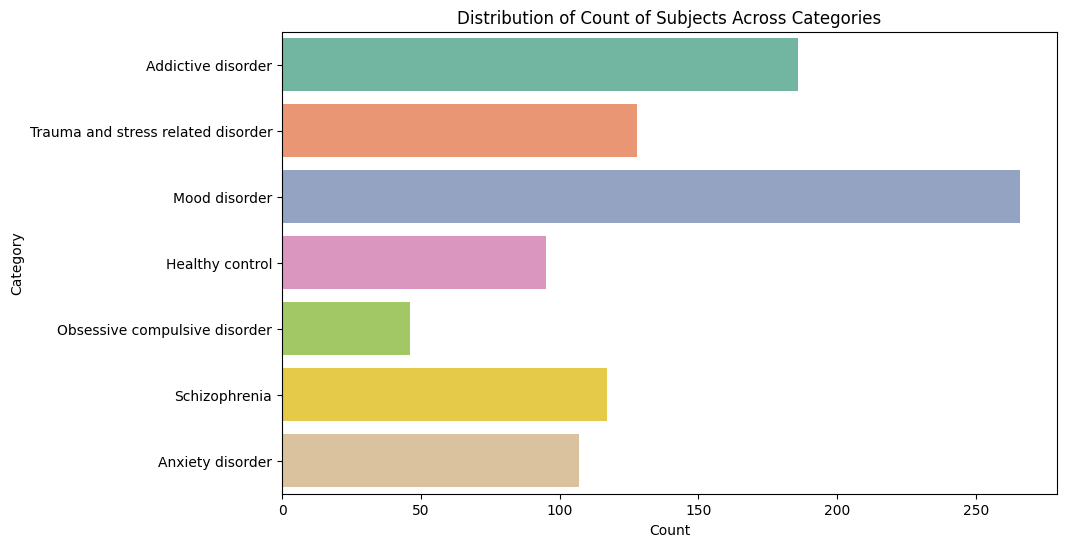

In [233]:

# @title # Visualizing
plt.figure(figsize=(10, 6))
sns.countplot(y=data["main.disorder"], palette='Set2')
plt.title('Distribution of Count of Subjects Across Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()



In [234]:
patient_eeg_data = data.iloc[:, 6:1149]
patient_eeg_data.rename(columns={"main.disorder": "main_disorder", "specific.disorder": "specific_disorder"}, inplace=True)
patient_eeg_data.head()

patient_eeg_data['main_disorder'].value_counts()


,count
main_disorder,
Mood disorder,266
Addictive disorder,186
Trauma and stress related disorder,128
Schizophrenia,117
Anxiety disorder,107
Healthy control,95
Obsessive compulsive disorder,46


In [235]:
# @title #LabelEncoding Categorical values

labelencoder=LabelEncoder()
patient_eeg_data['main_disorder']=labelencoder.fit_transform(patient_eeg_data['main_disorder'])
patient_eeg_data.head()
patient_eeg_data.drop(columns=['specific_disorder'], inplace=True)


In [236]:
# @title #Formatting Column names
def reformat_name(name):
    splitted = name.split(sep='.')

    if len(splitted) < 5:
        return name

    if splitted[0] == 'COH':
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}'

    return result

# Rename columns in the DataFrame
patient_eeg_data.columns = [
    reformat_name(col) if col.startswith('AB') or col.startswith('COH') else col
    for col in patient_eeg_data.columns
]

# Display the modified DataFrame
patient_eeg_data.head()


,main_disorder,AB.delta.FP1,AB.delta.FP2,AB.delta.F7,AB.delta.F3,AB.delta.Fz,AB.delta.F4,AB.delta.F8,AB.delta.T3,AB.delta.C3,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,0,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,0,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,0,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,0,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [237]:
patient_eeg_data.columns = patient_eeg_data.columns.str.replace('highbeta', 'high', regex=False)

print(patient_eeg_data.columns)

Index(['main_disorder', 'AB.delta.FP1', 'AB.delta.FP2', 'AB.delta.F7',
       'AB.delta.F3', 'AB.delta.Fz', 'AB.delta.F4', 'AB.delta.F8',
       'AB.delta.T3', 'AB.delta.C3',
       ...
       'COH.gamma.Pz.P4', 'COH.gamma.Pz.T6', 'COH.gamma.Pz.O1',
       'COH.gamma.Pz.O2', 'COH.gamma.P4.T6', 'COH.gamma.P4.O1',
       'COH.gamma.P4.O2', 'COH.gamma.T6.O1', 'COH.gamma.T6.O2',
       'COH.gamma.O1.O2'],
      dtype='object', length=1141)


In [238]:
# @title # PSD and FC
Nodes = [col for col in patient_eeg_data.columns if 'AB' in col]
Edges = [col for col in patient_eeg_data.columns if 'COH' in col]

print("Nodes Columns:", Nodes)
print("Edge Columns:", Edges)
print("Total Nodes:", len(Nodes))
print("Total Edges:", len(Edges))

Nodes Columns: ['AB.delta.FP1', 'AB.delta.FP2', 'AB.delta.F7', 'AB.delta.F3', 'AB.delta.Fz', 'AB.delta.F4', 'AB.delta.F8', 'AB.delta.T3', 'AB.delta.C3', 'AB.delta.Cz', 'AB.delta.C4', 'AB.delta.T4', 'AB.delta.T5', 'AB.delta.P3', 'AB.delta.Pz', 'AB.delta.P4', 'AB.delta.T6', 'AB.delta.O1', 'AB.delta.O2', 'AB.theta.FP1', 'AB.theta.FP2', 'AB.theta.F7', 'AB.theta.F3', 'AB.theta.Fz', 'AB.theta.F4', 'AB.theta.F8', 'AB.theta.T3', 'AB.theta.C3', 'AB.theta.Cz', 'AB.theta.C4', 'AB.theta.T4', 'AB.theta.T5', 'AB.theta.P3', 'AB.theta.Pz', 'AB.theta.P4', 'AB.theta.T6', 'AB.theta.O1', 'AB.theta.O2', 'AB.alpha.FP1', 'AB.alpha.FP2', 'AB.alpha.F7', 'AB.alpha.F3', 'AB.alpha.Fz', 'AB.alpha.F4', 'AB.alpha.F8', 'AB.alpha.T3', 'AB.alpha.C3', 'AB.alpha.Cz', 'AB.alpha.C4', 'AB.alpha.T4', 'AB.alpha.T5', 'AB.alpha.P3', 'AB.alpha.Pz', 'AB.alpha.P4', 'AB.alpha.T6', 'AB.alpha.O1', 'AB.alpha.O2', 'AB.beta.FP1', 'AB.beta.FP2', 'AB.beta.F7', 'AB.beta.F3', 'AB.beta.Fz', 'AB.beta.F4', 'AB.beta.F8', 'AB.beta.T3', 'AB.beta.

In [239]:
# @title #Scaled PSD and FC
scaler = StandardScaler()
patient_eeg_data[Nodes] = scaler.fit_transform(patient_eeg_data[Nodes])
patient_eeg_data[Edges] = scaler.fit_transform(patient_eeg_data[Edges])
patient_eeg_data.head()

,main_disorder,AB.delta.FP1,AB.delta.FP2,AB.delta.F7,AB.delta.F3,AB.delta.Fz,AB.delta.F4,AB.delta.F8,AB.delta.T3,AB.delta.C3,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,0,1.402585,0.044158,0.376937,0.873128,0.633045,0.675020,-0.051667,2.464746,0.727570,...,-1.255291,-1.961407,-1.829304,-0.834677,-2.238760,-1.572719,-1.056563,-1.437867,-1.750438,-1.451943
1,0,-0.599307,-0.832339,-0.580802,-0.399957,-0.646505,-0.760662,-0.928586,-0.247131,-0.190612,...,-1.910903,-1.921925,-1.647775,-1.803331,-0.718020,-0.787133,-0.380797,-1.222354,-0.460279,-0.693881
2,0,0.865449,0.520861,-0.059950,0.518725,0.681957,-0.643312,-0.055924,0.134177,0.640704,...,1.487760,0.798964,-0.973313,0.508876,0.069677,-0.474096,0.180730,-0.583297,-0.074676,-1.305296
3,0,0.116467,0.054748,-0.038530,-0.558477,-0.651703,-0.690924,-0.262061,-0.507484,-0.654060,...,-1.003143,0.449174,-1.118166,-0.754969,0.837050,-1.176012,-0.971431,-0.191613,0.756112,-0.812381
4,0,1.560186,1.016844,0.411670,0.316233,0.247229,0.212601,-0.115804,-0.320787,-0.140892,...,-0.910029,0.210786,-0.299953,-0.116595,0.612801,0.725577,0.532087,1.044399,1.178291,0.687884


In [240]:
# @title # Node Feature Matrix over 6 Frequency Bands

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma','high']
node_features = []

for band in bands:
    band_cols = [col for col in Nodes if band in col]
    print(f"Columns for {band}: {len(band_cols)}")

    node_band_data = patient_eeg_data[band_cols].values
    node_features.append(node_band_data)

for i, features in enumerate(node_features):
    print(f"Band {bands[i]} node feature shape: {features.shape}")

node_features = np.stack(node_features, axis=2)
print("Final node feature shape:", node_features.shape)


Columns for delta: 19
Columns for theta: 19
Columns for alpha: 19
Columns for beta: 19
Columns for gamma: 19
Columns for high: 19
Band delta node feature shape: (945, 19)
Band theta node feature shape: (945, 19)
Band alpha node feature shape: (945, 19)
Band beta node feature shape: (945, 19)
Band gamma node feature shape: (945, 19)
Band high node feature shape: (945, 19)
Final node feature shape: (945, 19, 6)


In [241]:
# @title #Edge Indices

edge_indices = []
edge_names = []
for col in Edges[:171]:
    electrodes = col.split('.')[2:4]
    band = col.split('.')[1]

    source_idx = Nodes.index(f'AB.{band}.{electrodes[0]}')
    target_idx = Nodes.index(f'AB.{band}.{electrodes[1]}')

    if source_idx != -1 and target_idx != -1:
        edge_indices.append((source_idx, target_idx))
        edge_names.append((electrodes[0], electrodes[1]))

edge_indices_tensor = torch.tensor(edge_indices, dtype=torch.long).t()


print("Edge indices shape:", edge_indices_tensor.shape)
print("Edge indices:\n", edge_indices_tensor)
print("Electrode pairs:\n", edge_names)


Edge indices shape: torch.Size([2, 171])
Edge indices:
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14,
         14, 14, 14, 15, 15, 15, 16, 16, 17],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  3,
       

In [242]:

# @title #Edge Feature Matrix

edge_attributes = []
for band in bands:
    band_cols = [col for col in Edges if band in col]
    edge_band_data = patient_eeg_data[band_cols].values
    edge_attributes.append(edge_band_data)

print("Edge attributes shape:", len(edge_attributes))

for i, attributes in enumerate(edge_attributes):
    print(f"Band {bands[i]} edge attribute shape: {attributes.shape}")
edge_attributes = np.stack(edge_attributes, axis=2)

print("Edge attributes shape:", edge_attributes.shape)


Edge attributes shape: 6
Band delta edge attribute shape: (945, 171)
Band theta edge attribute shape: (945, 171)
Band alpha edge attribute shape: (945, 171)
Band beta edge attribute shape: (945, 171)
Band gamma edge attribute shape: (945, 171)
Band high edge attribute shape: (945, 171)
Edge attributes shape: (945, 171, 6)


In [243]:
#@title #Creating 945 Graphs for each subject
graphs = []
for i in range(node_features.shape[0]):
    node_feature_matrix = torch.tensor(node_features[i], dtype=torch.float)
    edge_attr_matrix = torch.tensor(edge_attributes[i], dtype=torch.float)
    label = torch.tensor(patient_eeg_data["main_disorder"].values[i], dtype=torch.long)
    graph = Data(
        x=node_feature_matrix,
        edge_index=edge_indices_tensor,
        edge_attr=edge_attr_matrix,
        y=label
    )
    graphs.append(graph)



In [244]:


#@title #Fixing the Class Imbalance Problem

X = np.array([graph.x.flatten().numpy() for graph in graphs])
y = np.array([graph.y.item() for graph in graphs])

class_graphs = {label: [] for label in np.unique(y)}
for graph, label in zip(graphs, y):
    class_graphs[label].append(graph)

smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

balanced_graphs = []
target_counts = Counter(y_resampled)

for label, count in target_counts.items():
    samples = class_graphs[label]
    if len(samples) < count:
        oversampled_samples = resample(samples, replace=True, n_samples=count, random_state=42)
        balanced_graphs.extend(oversampled_samples)
    else:
        balanced_graphs.extend(samples)

np.random.shuffle(balanced_graphs)

In [245]:
print("Label counts after SMOTE:")
for label, count in target_counts.items():
    print(f"Label {label}: {count} instances")

Label counts after SMOTE:
Label 0: 266 instances
Label 6: 266 instances
Label 3: 266 instances
Label 2: 266 instances
Label 4: 266 instances
Label 5: 266 instances
Label 1: 266 instances


In [246]:

# @title # Split the balanced graphs into training and testing sets (80% train, 20% test)
train_graphs_gcn, test_graphs_gcn = train_test_split(balanced_graphs, test_size=0.2, random_state=42)

train_loader_gcn = DataLoader(train_graphs_gcn, batch_size=32, shuffle=True, drop_last=True)
test_loader_gcn = DataLoader(test_graphs_gcn, batch_size=32, shuffle=True, drop_last=True)

train_graphs_sage, test_graphs_sage = train_test_split(balanced_graphs, test_size=0.2, random_state=42)
train_loader_sage = DataLoader(train_graphs_sage, batch_size=32, shuffle=True, drop_last=True)
test_loader_sage = DataLoader(test_graphs_sage, batch_size=32, shuffle=True, drop_last=True)

train_graphs_gin, test_graphs_gin = train_test_split(balanced_graphs, test_size=0.2, random_state=42)
train_loader_gin = DataLoader(train_graphs_gin, batch_size=32, shuffle=True, drop_last=True)
test_loader_gin = DataLoader(test_graphs_gin, batch_size=32, shuffle=True, drop_last=True)

train_graphs_gat, test_graphs_gat = train_test_split(balanced_graphs, test_size=0.2, random_state=42)
train_loader_gat = DataLoader(train_graphs_gat, batch_size=32, shuffle=True, drop_last=True)
test_loader_gat = DataLoader(test_graphs_gat, batch_size=32, shuffle=True, drop_last=True)

print(f"Training graphs for GCN: {len(train_graphs_gcn)}")
print(f"Testing graphs for GCN: {len(test_graphs_gcn)}")
print(f"Training graphs for GraphSAGE: {len(train_graphs_sage)}")
print(f"Testing graphs for GraphSAGE: {len(test_graphs_sage)}")
print(f"Training graphs for GIN: {len(train_graphs_gin)}")
print(f"Testing graphs for GIN: {len(test_graphs_gin)}")
print(f"Training graphs for GAT: {len(train_graphs_gat)}")
print(f"Testing graphs for GAT: {len(test_graphs_gat)}")


Training graphs for GCN: 1489
Testing graphs for GCN: 373
Training graphs for GraphSAGE: 1489
Testing graphs for GraphSAGE: 373
Training graphs for GIN: 1489
Testing graphs for GIN: 373
Training graphs for GAT: 1489
Testing graphs for GAT: 373


In [247]:
print("Total Graph is: ",len(balanced_graphs))

Total Graph is:  1862


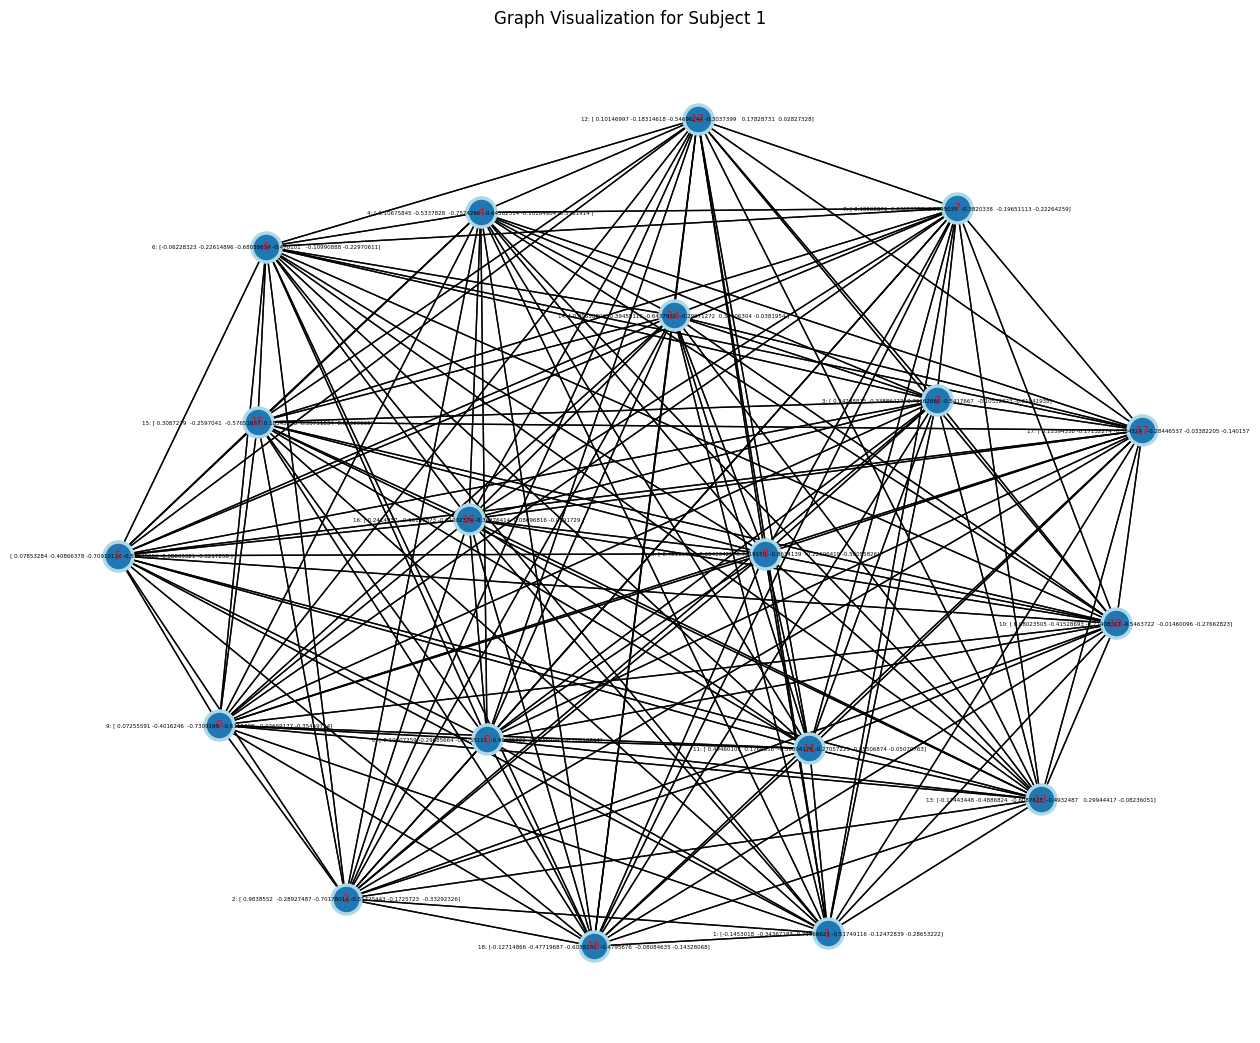

In [248]:
# @title #Plotting One of the Subjects Graph
from torch_geometric.utils import to_networkx
import networkx as nx
subject_graph = balanced_graphs[0]
G = to_networkx(subject_graph, to_undirected=True)

node_labels = {i: f"{i}: {subject_graph.x[i].numpy()}" for i in range(subject_graph.x.shape[0])}

plt.figure(figsize=(16, 13))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.8)

nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=4)



nx.draw_networkx(G, pos, font_color='red',font_size=8)

plt.title("Graph Visualization for Subject 1")
plt.axis('off')
plt.show()


In [249]:
# @title #One of the Subjects Graph information
first_graph = balanced_graphs[0]

print(f"Graph info : {first_graph}")
print(f" - Number of nodes: {first_graph.num_nodes}")
print(f" - Number of edges: {first_graph.num_edges}")
print(f" - Node feature shape: {first_graph.x.shape}")
print(f" - Edge index shape: {first_graph.edge_index.shape}")
print(f" - Edge attribute shape: {first_graph.edge_attr.shape}")
print(f" - Graph label: {first_graph.y.item()}\n")





Graph info : Data(x=[19, 6], edge_index=[2, 171], edge_attr=[171, 6], y=2)
 - Number of nodes: 19
 - Number of edges: 171
 - Node feature shape: torch.Size([19, 6])
 - Edge index shape: torch.Size([2, 171])
 - Edge attribute shape: torch.Size([171, 6])
 - Graph label: 2



In [250]:
# @title #GCN MODEL
class GCNModel(nn.Module):
    def __init__(self):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNConv(6, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.gcn2 = GCNConv(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.gcn3 = GCNConv(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64, len(labelencoder.classes_))
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.bn1(self.gcn1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.gcn2(x, edge_index)))
        x = self.dropout(x)
        x = self.gcn3(x, edge_index)
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [251]:
# @title #GraphSage Model

class GraphSageModel(nn.Module):
    def __init__(self):
        super(GraphSageModel, self).__init__()
        self.sage1 = SAGEConv(6, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.sage2 = SAGEConv(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.sage3 = SAGEConv(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, 7)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.bn1(self.sage1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.sage2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.sage3(x, edge_index)))
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)




In [252]:
from torch_geometric.nn import GINConv
# @title #GIN Model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool

class GINModel(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(GINModel, self).__init__()
        self.gin1 = GINConv(nn.Linear(6, 128), train_eps=True)
        self.gin2 = GINConv(nn.Linear(128, 256), train_eps=True)
        self.gin3 = GINConv(nn.Linear(256, 256), train_eps=True)
        self.fc = nn.Linear(256, len(labelencoder.classes_))
        self.dropout_rate = dropout_rate
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gin1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.gin2(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.gin3(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [253]:
# @title #Evaluation
learning_rate = 0.001
weight_decay = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            _, preds = output.max(dim=1)
            all_labels.append(data.y.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds)

def train_and_evaluate(model_class, model_name, train_loader, test_loader):
    print(f"\nTraining {model_name} model...")
    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    class_weights = [1 / (len(patient_eeg_data) / sum(patient_eeg_data['main_disorder'] == i)) for i in range(len(labelencoder.classes_))]
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_test_accuracy = 0
    best_train_accuracy = 0
    epochs_no_improve = 0
    best_model = model

    for epoch in range(1, 201):
        model.train()
        total_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_labels, train_preds = evaluate(train_loader, model)
        test_labels, test_preds = evaluate(test_loader, model)
        train_accuracy = np.mean(train_preds == train_labels) * 100
        test_accuracy = np.mean(test_preds == test_labels) * 100
        if epoch % 5 == 0:
          print(f"Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model = model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == 20:
            print(f"Early stopping triggered for {model_name} model.")
            break

    print(f"Best Train Accuracy for {model_name}: {best_train_accuracy:.2f}%")
    print(f"Best Test Accuracy for {model_name}: {best_test_accuracy:.2f}%")

    return best_model



In [254]:
#@title #Evaluating Models
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    return y_true, y_pred

In [255]:
#@title #GCN  Classification Report
gcn_model = train_and_evaluate(GCNModel, "GCN", train_loader_gcn, test_loader_gcn)


y_true_gcn, y_pred_gcn = evaluate_model(gcn_model, train_loader_gcn)
print("GCN Train Classification Report:\n", classification_report(y_true_gcn, y_pred_gcn, target_names=labelencoder.classes_))
print("GCN Train Confusion Matrix:\n", confusion_matrix(y_true_gcn, y_pred_gcn))


y_true_gcn, y_pred_gcn = evaluate_model(gcn_model, test_loader_gcn)
print("GCN Test Classification Report:\n", classification_report(y_true_gcn, y_pred_gcn, target_names=labelencoder.classes_))
print("GCN Test Confusion Matrix:\n", confusion_matrix(y_true_gcn, y_pred_gcn))



Training GCN model...
Epoch 5: Train Accuracy: 26.22%, Test Accuracy: 19.60%
Epoch 10: Train Accuracy: 27.65%, Test Accuracy: 18.18%
Epoch 15: Train Accuracy: 31.59%, Test Accuracy: 23.30%
Epoch 20: Train Accuracy: 34.85%, Test Accuracy: 24.15%
Epoch 25: Train Accuracy: 36.55%, Test Accuracy: 24.72%
Epoch 30: Train Accuracy: 37.50%, Test Accuracy: 21.59%
Epoch 35: Train Accuracy: 43.95%, Test Accuracy: 33.52%
Epoch 40: Train Accuracy: 41.03%, Test Accuracy: 28.98%
Epoch 45: Train Accuracy: 42.87%, Test Accuracy: 31.25%
Epoch 50: Train Accuracy: 47.28%, Test Accuracy: 34.94%
Epoch 55: Train Accuracy: 49.73%, Test Accuracy: 38.35%
Epoch 60: Train Accuracy: 46.60%, Test Accuracy: 33.24%
Epoch 65: Train Accuracy: 49.46%, Test Accuracy: 36.93%
Epoch 70: Train Accuracy: 50.27%, Test Accuracy: 37.50%
Epoch 75: Train Accuracy: 50.00%, Test Accuracy: 38.92%
Epoch 80: Train Accuracy: 52.85%, Test Accuracy: 38.35%
Epoch 85: Train Accuracy: 55.37%, Test Accuracy: 42.90%
Epoch 90: Train Accuracy: 

In [256]:
# @title #GraphSage  Classification Report
graph_sage_model = train_and_evaluate(GraphSageModel, "GraphSAGE", train_loader_sage, test_loader_sage)

y_true_sage, y_pred_sage = evaluate_model(graph_sage_model, train_loader_sage)
print("GraphSAGE Classification Report:\n", classification_report(y_true_sage, y_pred_sage, target_names=labelencoder.classes_))
print("GraphSAGE Confusion Matrix:\n", confusion_matrix(y_true_sage, y_pred_sage))



y_true_sage, y_pred_sage = evaluate_model(graph_sage_model, test_loader_sage)
print("GraphSAGE Classification Report:\n", classification_report(y_true_sage, y_pred_sage, target_names=labelencoder.classes_))
print("GraphSAGE Confusion Matrix:\n", confusion_matrix(y_true_sage, y_pred_sage))




Training GraphSAGE model...
Epoch 5: Train Accuracy: 32.81%, Test Accuracy: 22.44%
Epoch 10: Train Accuracy: 39.88%, Test Accuracy: 30.68%
Epoch 15: Train Accuracy: 48.71%, Test Accuracy: 36.65%
Epoch 20: Train Accuracy: 53.26%, Test Accuracy: 41.48%
Epoch 25: Train Accuracy: 55.50%, Test Accuracy: 40.91%
Epoch 30: Train Accuracy: 64.88%, Test Accuracy: 47.44%
Epoch 35: Train Accuracy: 67.73%, Test Accuracy: 47.73%
Epoch 40: Train Accuracy: 72.69%, Test Accuracy: 54.55%
Epoch 45: Train Accuracy: 76.15%, Test Accuracy: 57.10%
Epoch 50: Train Accuracy: 75.75%, Test Accuracy: 57.39%
Epoch 55: Train Accuracy: 79.89%, Test Accuracy: 58.24%
Epoch 60: Train Accuracy: 81.59%, Test Accuracy: 61.93%
Epoch 65: Train Accuracy: 82.13%, Test Accuracy: 62.50%
Epoch 70: Train Accuracy: 84.04%, Test Accuracy: 63.35%
Epoch 75: Train Accuracy: 87.30%, Test Accuracy: 66.76%
Epoch 80: Train Accuracy: 89.40%, Test Accuracy: 67.61%
Epoch 85: Train Accuracy: 87.64%, Test Accuracy: 65.62%
Epoch 90: Train Accu

In [258]:
#@title #GIN Model Classification Report
gin_model=train_and_evaluate(GINModel,"Graph_iso",train_loader_gin,test_loader_gin)


y_true_gin, y_pred_gin = evaluate_model(gin_model, train_loader_gin)
print("GIN Train Classification Report:\n", classification_report(y_true_gin, y_pred_gin, target_names=labelencoder.classes_))
print("GIN Confusion Matrix:\n", confusion_matrix(y_true_gin, y_pred_gin))


y_true_gin, y_pred_gin = evaluate_model(gin_model, test_loader_gin)
print("GIN Test Classification Report:\n", classification_report(y_true_gin, y_pred_gin, target_names=labelencoder.classes_))
print("GIN Confusion Matrix:\n", confusion_matrix(y_true_gin, y_pred_gin))



Training Graph_iso model...
Epoch 5: Train Accuracy: 45.31%, Test Accuracy: 33.81%
Epoch 10: Train Accuracy: 59.44%, Test Accuracy: 46.02%
Epoch 15: Train Accuracy: 71.67%, Test Accuracy: 52.27%
Epoch 20: Train Accuracy: 75.00%, Test Accuracy: 53.69%
Epoch 25: Train Accuracy: 77.92%, Test Accuracy: 55.40%
Epoch 30: Train Accuracy: 82.88%, Test Accuracy: 62.50%
Epoch 35: Train Accuracy: 81.93%, Test Accuracy: 60.23%
Epoch 40: Train Accuracy: 87.23%, Test Accuracy: 64.20%
Epoch 45: Train Accuracy: 89.33%, Test Accuracy: 66.76%
Epoch 50: Train Accuracy: 93.55%, Test Accuracy: 71.02%
Epoch 55: Train Accuracy: 90.90%, Test Accuracy: 71.02%
Epoch 60: Train Accuracy: 91.37%, Test Accuracy: 69.32%
Epoch 65: Train Accuracy: 92.87%, Test Accuracy: 71.59%
Epoch 70: Train Accuracy: 94.16%, Test Accuracy: 71.59%
Epoch 75: Train Accuracy: 96.74%, Test Accuracy: 72.16%
Epoch 80: Train Accuracy: 96.47%, Test Accuracy: 76.14%
Epoch 85: Train Accuracy: 96.60%, Test Accuracy: 75.85%
Epoch 90: Train Accu